In [3]:
import gymnasium as gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('Pendulum-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self,**kwargs):
        self.step_n = 0
        return self.env.reset(**kwargs)


    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)

        #一局游戏最多走N步
        self.step_n += 1
        if self.step_n >= 200:
            terminated = True

        return state, reward, terminated, truncated, info


env = MyWrapper()

env.reset()


(array([ 0.3957838 ,  0.9183437 , -0.14259829], dtype=float32), {})

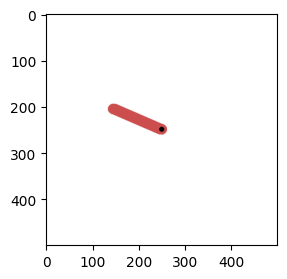

In [4]:
from matplotlib import pyplot as plt

%matplotlib inline


#打印游戏
def show():
    plt.figure(figsize=(3, 3))
    plt.imshow(env.render())
    plt.show()


show()

In [7]:
#认识游戏环境
def test_env():
    print('env.observation_space=', env.observation_space)
    print('env.action_space=', env.action_space)

    state, probs = env.reset()
    action = env.action_space.sample()
    next_state, reward, terminated, truncated, info  = env.step(action)

    print('state=', state)
    print('action=', action)
    print('next_state=', next_state)
    print('reward=', reward)
    print('done=', terminated)
    print('probs=',probs)


test_env()

env.observation_space= Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
env.action_space= Box(-2.0, 2.0, (1,), float32)
state= [ 0.942665   -0.33374056  0.22836065]
action= [1.6563636]
next_state= [ 0.9463842  -0.32304326  0.22650978]
reward= -0.1237413053281207
done= False
probs= {}


In [12]:

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#计算动作的模型,也是真正要用的模型
model = torch.nn.Sequential(
    torch.nn.Linear(3, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 11),
).to(device)

#经验网络,用于评估一个状态的分数
target_model = torch.nn.Sequential(
    torch.nn.Linear(3, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 11),
).to(device)

#把model的参数复制给next_model
target_model.load_state_dict(model.state_dict())

model, target_model

(Sequential(
   (0): Linear(in_features=3, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=11, bias=True)
 ),
 Sequential(
   (0): Linear(in_features=3, out_features=128, bias=True)
   (1): ReLU()
   (2): Linear(in_features=128, out_features=11, bias=True)
 ))

In [13]:
import random


def get_action(state):
    #走神经网络,得到一个动作
    state = torch.FloatTensor(state).reshape(1, 3).to(device) #batch_size, state_size
    # print(state)
    action = model(state).argmax().item()

    if random.random() < 0.01:
        action = random.choice(range(11))

    #离散动作连续化
    action_continuous = action
    action_continuous /= 10
    action_continuous *= 4
    action_continuous -= 2

    return action, action_continuous


get_action([0.29292667, 0.9561349, 1.0957013])

tensor([[0.2929, 0.9561, 1.0957]], device='cuda:0')


(5, 0.0)

In [15]:
#样本池
datas = []


#向样本池中添加N条数据,删除M条最古老的数据
def update_data():
    old_count = len(datas)

    #玩到新增了N个数据为止
    while len(datas) - old_count < 200:
        #初始化游戏
        state, _ = env.reset()

        #玩到游戏结束为止
        terminated = False
        while not terminated:
            #根据当前状态得到一个动作
            action, action_continuous = get_action(state)

            #执行动作,得到反馈
            next_state, reward, terminated, truncated, info= env.step([action_continuous])

            #记录数据样本
            datas.append((state, action, reward, next_state, terminated))

            #更新游戏状态,开始下一个动作
            state = next_state

    #数据上限,超出时从最古老的开始删除
    while len(datas) > 5000:
        datas.pop(0)


update_data()

len(datas)

tensor([[ 0.9926, -0.1212, -0.7140]], device='cuda:0')
tensor([[ 0.9849, -0.1729, -1.0449]], device='cuda:0')
tensor([[ 0.9703, -0.2420, -1.4145]], device='cuda:0')
tensor([[ 0.9440, -0.3300, -1.8361]], device='cuda:0')
tensor([[ 0.8994, -0.4372, -2.3235]], device='cuda:0')
tensor([[ 0.8270, -0.5622, -2.8914]], device='cuda:0')
tensor([[ 0.7147, -0.6995, -3.5530]], device='cuda:0')
tensor([[ 0.5482, -0.8363, -4.3176]], device='cuda:0')
tensor([[ 0.3155, -0.9489, -5.1849]], device='cuda:0')
tensor([[ 0.0142, -0.9999, -6.1365]], device='cuda:0')
tensor([[-0.3355, -0.9420, -7.1265]], device='cuda:0')
tensor([[-0.6759, -0.7370, -8.0000]], device='cuda:0')
tensor([[-0.9095, -0.4157, -8.0000]], device='cuda:0')
tensor([[-0.9996, -0.0287, -8.0000]], device='cuda:0')
tensor([[-0.9318,  0.3629, -8.0000]], device='cuda:0')
tensor([[-0.7181,  0.6959, -7.9679]], device='cuda:0')
tensor([[-0.4048,  0.9144, -7.6859]], device='cuda:0')
tensor([[-0.0547,  0.9985, -7.2401]], device='cuda:0')
tensor([[ 

200

In [16]:
#获取一批数据样本
def get_sample():
    #从样本池中采样
    samples = random.sample(datas, 64)

    #[b, 3]
    state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3).to(device)
    #[b, 1]
    action = torch.LongTensor([i[1] for i in samples]).reshape(-1, 1).to(device)
    #[b, 1]
    reward = torch.FloatTensor([i[2] for i in samples]).reshape(-1, 1).to(device)
    #[b, 3]
    next_state = torch.FloatTensor([i[3] for i in samples]).reshape(-1, 3).to(device)
    #[b, 1]
    over = torch.LongTensor([i[4] for i in samples]).reshape(-1, 1).to(device)

    return state, action, reward, next_state, over


state, action, reward, next_state, over = get_sample()

state, action, reward, next_state, over

C:\Users\13306\AppData\Local\Temp\ipykernel_32912\942545437.py:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:233.)
  state = torch.FloatTensor([i[0] for i in samples]).reshape(-1, 3).to(device)


(tensor([[ 6.5014e-01,  7.5982e-01, -6.0624e+00],
         [-8.3791e-01, -5.4581e-01, -8.0000e+00],
         [-5.5922e-01, -8.2902e-01, -8.0000e+00],
         [ 9.9520e-01, -9.7854e-02, -5.6799e+00],
         [-1.8660e-01,  9.8244e-01, -7.4064e+00],
         [ 6.7195e-01, -7.4060e-01, -6.7227e+00],
         [-7.7788e-01,  6.2841e-01, -8.0000e+00],
         [-4.8079e-01, -8.7684e-01, -8.0000e+00],
         [-9.9652e-01,  8.3386e-02, -8.0000e+00],
         [-6.0543e-01, -7.9590e-01, -8.0000e+00],
         [-2.4831e-03,  1.0000e+00, -7.1490e+00],
         [ 9.6463e-01,  2.6359e-01, -5.5595e+00],
         [-9.0725e-01,  4.2058e-01, -8.0000e+00],
         [ 3.4835e-01,  9.3737e-01, -6.5919e+00],
         [ 1.4192e-02, -9.9990e-01, -6.1365e+00],
         [ 2.0509e-01, -9.7874e-01, -7.8539e+00],
         [-4.6568e-01, -8.8495e-01, -8.0000e+00],
         [-9.6119e-01,  2.7589e-01, -8.0000e+00],
         [-4.8828e-03, -9.9999e-01, -8.0000e+00],
         [-3.1086e-01, -9.5046e-01, -8.0000e+00],


In [17]:
def get_value(state, action):
    #使用状态计算出动作的logits
    #[b, 3] -> [b, 11]
    value = model(state)

    #根据实际使用的action取出每一个值
    #这个值就是模型评估的在该状态下,执行动作的分数
    #在执行动作前,显然并不知道会得到的反馈和next_state
    #所以这里不能也不需要考虑next_state和reward
    #[b, 11] -> [b, 1]
    value = value.gather(dim=1, index=action)

    return value


get_value(state, action)

tensor([[2.7136],
        [2.9274],
        [2.9131],
        [2.4443],
        [3.1468],
        [2.6480],
        [3.2126],
        [2.9149],
        [3.0510],
        [2.9119],
        [3.0770],
        [2.4666],
        [3.1449],
        [2.9092],
        [2.2764],
        [2.9445],
        [2.9154],
        [3.1020],
        [2.9600],
        [2.9229],
        [3.1730],
        [2.6334],
        [2.9752],
        [2.6532],
        [2.4487],
        [3.2154],
        [2.4466],
        [3.2237],
        [2.4820],
        [2.4461],
        [1.0091],
        [3.1157],
        [1.5064],
        [3.1041],
        [2.5729],
        [2.6378],
        [2.5087],
        [3.1546],
        [0.8657],
        [3.1852],
        [2.7401],
        [0.7464],
        [3.0040],
        [2.4515],
        [2.9331],
        [3.2217],
        [2.4992],
        [2.9073],
        [3.2233],
        [2.9746],
        [2.9139],
        [2.4458],
        [2.9546],
        [2.6912],
        [2.8009],
        [2

In [18]:
def get_target(reward, next_state, over):
    #上面已经把模型认为的状态下执行动作的分数给评估出来了
    #下面使用next_state和reward计算真实的分数
    #针对一个状态,它到底应该多少分,可以使用以往模型积累的经验评估
    #这也是没办法的办法,因为显然没有精确解,这里使用延迟更新的next_model评估

    #使用next_state计算下一个状态的分数
    #[b, 3] -> [b, 11]
    with torch.no_grad():
        target = target_model(next_state)

    #取所有动作中分数最大的
    #[b, 11] -> [b, 1]
    target = target.max(dim=1)[0]
    target = target.reshape(-1, 1)

    #下一个状态的分数乘以一个系数,相当于权重
    target *= 0.98

    #如果next_state已经游戏结束,则next_state的分数是0
    #因为如果下一步已经游戏结束,显然不需要再继续玩下去,也就不需要考虑next_state了.
    #[b, 1] * [b, 1] -> [b, 1]
    target *= (1 - over)

    #加上reward就是最终的分数
    #[b, 1] + [b, 1] -> [b, 1]
    target += reward

    return target


get_target(reward, next_state, over)

tensor([[ -1.9055],
        [-10.0455],
        [ -8.2177],
        [ -0.7982],
        [ -5.6327],
        [ -2.4211],
        [ -9.3083],
        [ -7.8375],
        [-12.6588],
        [ -8.4601],
        [ -4.7225],
        [ -0.7807],
        [-10.5753],
        [ -3.1388],
        [ -3.6484],
        [ -5.1568],
        [ -7.7678],
        [-11.4457],
        [ -6.0248],
        [ -7.1095],
        [ -6.1282],
        [ -2.2710],
        [ -5.7490],
        [ -2.4681],
        [ -0.8557],
        [ -6.9502],
        [ -0.9055],
        [ -8.9748],
        [ -0.8356],
        [ -0.8729],
        [  0.6849],
        [ -5.1061],
        [ -0.1694],
        [ -4.9914],
        [ -1.8581],
        [ -2.3210],
        [ -1.3266],
        [-10.3917],
        [  0.7265],
        [ -9.8348],
        [ -2.0466],
        [  0.7064],
        [-12.4897],
        [ -0.8497],
        [ -3.3118],
        [ -8.2364],
        [ -0.8932],
        [ -4.6654],
        [ -8.8324],
        [-11.6514],


In [20]:
from IPython import display


def test(play=False):
    state,_ = env.reset()
    reward_sum = 0
    terminated = False
    while not terminated:
        _, action_continuous = get_action(state)
        state, reward, terminated, truncated, info = env.step([action_continuous])
        reward_sum += reward

        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


sum([test() for _ in range(20)]) / 20

tensor([[ 0.9070,  0.4211, -0.9771]], device='cuda:0')
tensor([[ 0.9251,  0.3798, -0.9013]], device='cuda:0')
tensor([[ 0.9405,  0.3399, -0.8564]], device='cuda:0')
tensor([[ 0.9539,  0.3000, -0.8415]], device='cuda:0')
tensor([[ 0.9659,  0.2589, -0.8565]], device='cuda:0')
tensor([[ 0.9766,  0.2151, -0.9024]], device='cuda:0')
tensor([[ 0.9860,  0.1669, -0.9811]], device='cuda:0')
tensor([[ 0.9936,  0.1127, -1.0959]], device='cuda:0')
tensor([[ 0.9987,  0.0503, -1.2514]], device='cuda:0')
tensor([[ 0.9998, -0.0224, -1.4537]], device='cuda:0')
tensor([[ 0.9942, -0.1077, -1.7104]], device='cuda:0')
tensor([[ 0.9781, -0.2079, -2.0312]], device='cuda:0')
tensor([[ 0.9458, -0.3248, -2.4271]], device='cuda:0')
tensor([[ 0.8887, -0.4585, -2.9107]], device='cuda:0')
tensor([[ 0.7954, -0.6060, -3.4946]], device='cuda:0')
tensor([[ 0.6521, -0.7582, -4.1891]], device='cuda:0')
tensor([[ 0.4443, -0.8959, -4.9977]], device='cuda:0')
tensor([[ 0.1642, -0.9864, -5.9096]], device='cuda:0')
tensor([[-

-1507.4462857611202

In [22]:
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
    loss_fn = torch.nn.MSELoss()

    #训练N次
    for epoch in range(200):
        #更新N条数据
        update_data()

        #每次更新过数据后,学习N次
        for i in range(200):
            #采样一批数据
            state, action, reward, next_state, over = get_sample()

            #计算一批样本的value和target
            value = get_value(state, action)
            target = get_target(reward, next_state, over)

            #更新参数
            loss = loss_fn(value, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #把model的参数复制给next_model
            if (i + 1) % 50 == 0:
                target_model.load_state_dict(model.state_dict())

        if epoch % 20 == 0:
            print(epoch, len(datas), sum([test() for _ in range(5)]) / 5)

    torch.save(model, 'save/5.DQN_Pendulum')


train()

tensor([[ 0.0929, -0.9957, -0.4836]], device='cuda:0')
tensor([[ 0.0165, -0.9999, -1.5304]], device='cuda:0')
tensor([[-0.1093, -0.9940, -2.5203]], device='cuda:0')
tensor([[-0.2810, -0.9597, -3.5058]], device='cuda:0')
tensor([[-0.4865, -0.8737, -4.4656]], device='cuda:0')
tensor([[-0.7005, -0.7136, -5.3608]], device='cuda:0')
tensor([[-0.8833, -0.4688, -6.1360]], device='cuda:0')
tensor([[-0.9885, -0.1509, -6.7276]], device='cuda:0')
tensor([[-0.9796,  0.2012, -7.0808]], device='cuda:0')
tensor([[-0.8467,  0.5321, -7.1699]], device='cuda:0')
tensor([[-0.6125,  0.7905, -7.0109]], device='cuda:0')
tensor([[-0.3206,  0.9472, -6.6580]], device='cuda:0')
tensor([[-0.0169,  0.9999, -6.1876]], device='cuda:0')
tensor([[ 0.2638,  0.9646, -5.6777]], device='cuda:0')
tensor([[ 0.5027,  0.8645, -5.1943]], device='cuda:0')
tensor([[ 0.6932,  0.7207, -4.7859]], device='cuda:0')
tensor([[ 0.8362,  0.5485, -4.4854]], device='cuda:0')
tensor([[ 0.9342,  0.3568, -4.3140]], device='cuda:0')
tensor([[ 

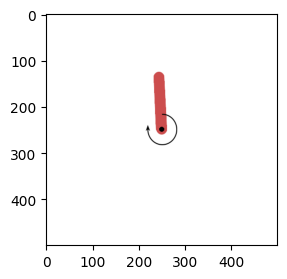

tensor([[ 0.9988,  0.0493, -0.0532]], device='cuda:0')
tensor([[0.9987, 0.0515, 0.0438]], device='cuda:0')
tensor([[ 0.9989,  0.0466, -0.0976]], device='cuda:0')
tensor([[ 0.9989,  0.0465, -0.0026]], device='cuda:0')
tensor([[ 0.9992,  0.0391, -0.1477]], device='cuda:0')
tensor([[0.9988, 0.0482, 0.1816]], device='cuda:0')
tensor([[0.9986, 0.0531, 0.0978]], device='cuda:0')
tensor([[ 0.9987,  0.0510, -0.0424]], device='cuda:0')


-672.3811736267397

In [34]:
model = torch.load('save/5.DQN_Pendulum')

test(play=True)